# IMDB Movie Review - Sentiment Analysis

Analyzing the IMDB Movie Review dataset and building classification models to predict if the sentiment of a given input sentence is positive or negative.

### Importing required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re

[nltk_data] Downloading package stopwords to C:\Users\HP  i5
[nltk_data]     11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
%pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


## IMDB Data

## IMDB Data

In [3]:
imdb = pd.read_csv(r"Data\IMDB.csv")

In [4]:
type(imdb)

pandas.core.frame.DataFrame

In [5]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
imdb['sentiment'] = imdb['sentiment'].apply(lambda e: 0 if e == "negative" else 1)

In [7]:
imdb.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [8]:
imdb.groupby('sentiment').count()

,review
sentiment,
0,25000
1,25000


In [9]:
imdb.describe()

,sentiment
count,50000.000000
mean,0.500000
std,0.500005
min,0.000000
25%,0.000000
50%,0.500000
75%,1.000000
max,1.000000


In [10]:
imdb.dtypes

review       object
sentiment     int64
dtype: object

### Sample Negative Reviews

In [11]:
imdb[imdb['sentiment'] == 0].head()

,review,sentiment
3,Basically there's a family where a little boy ...,0
7,"This show was an amazing, fresh & innovative i...",0
8,Encouraged by the positive comments about this...,0
10,Phil the Alien is one of those quirky films wh...,0
11,I saw this movie when I was about 12 when it c...,0


### Sample Positive Reviews

In [12]:
imdb[imdb['sentiment']==1].head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
4,"Petter Mattei's ""Love in the Time of Money"" is...",1
5,"Probably my all-time favorite movie, a story o...",1


### Exploratory Data Analysis

From the above 2 examples we can see that feedback **0 is negative review** and **1 is positive review**

Let's plot the feedback value count in a bar graph

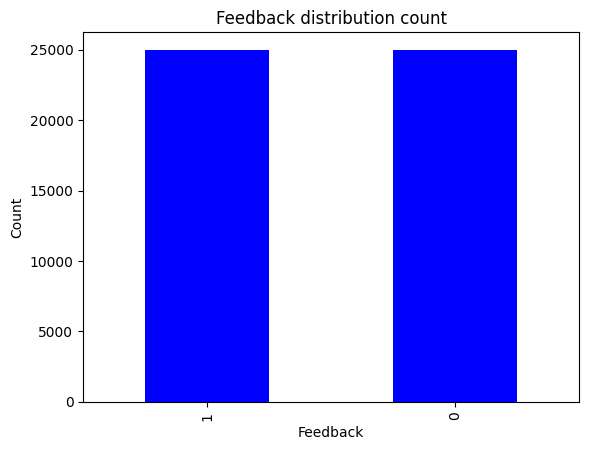

In [13]:
#Bar graph to visualize the total counts of each feedback

imdb['sentiment'].value_counts().plot.bar(color = 'blue')
plt.title('Feedback distribution count')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.show()

In [14]:
#Finding the percentage distribution of each feedback - we'll divide the number of records for each feedback by total number of records

print(f"Feedback value count - percentage distribution: \n{round(imdb['sentiment'].value_counts()/imdb.shape[0]*100,2)}")

Feedback value count - percentage distribution: 
sentiment
1    50.0
0    50.0
Name: count, dtype: float64


<Axes: ylabel='Percentage wise distrubution of feedback'>

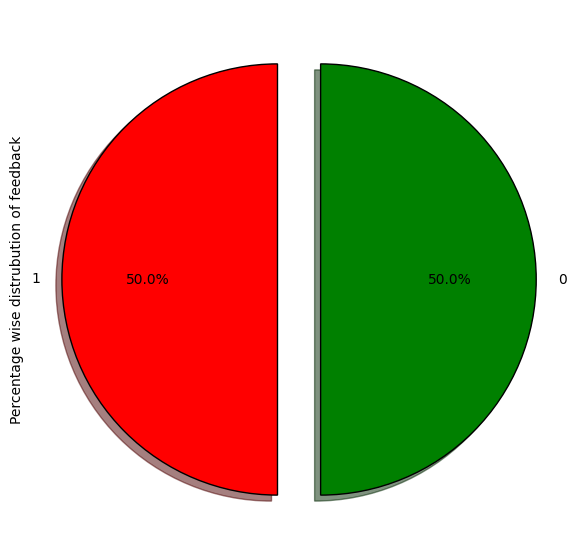

In [15]:
fig = plt.figure(figsize=(7,7))
colors = ('red', 'green')
wp = {'linewidth':1, "edgecolor":'black'}
tags = imdb['sentiment'].value_counts()/imdb.shape[0]
explode=(0.1,0.1)
tags.plot(kind='pie', autopct="%1.1f%%", shadow=True, colors=colors, startangle=90, wedgeprops=wp, explode=explode, label='Percentage wise distrubution of feedback')

[Text(0.5, 1.0, 'Distribution of length of review ')]

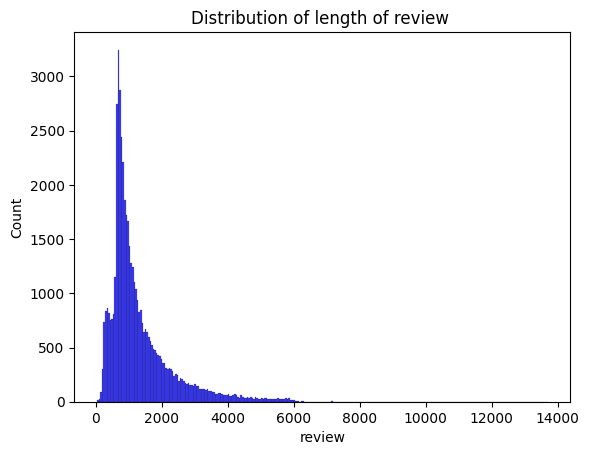

In [16]:
sns.histplot(imdb['review'].apply(lambda e:len(e)),color='blue').set(title='Distribution of length of review ')

Length analysis when feedback is 0 (negative)

In [17]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(imdb['review'])

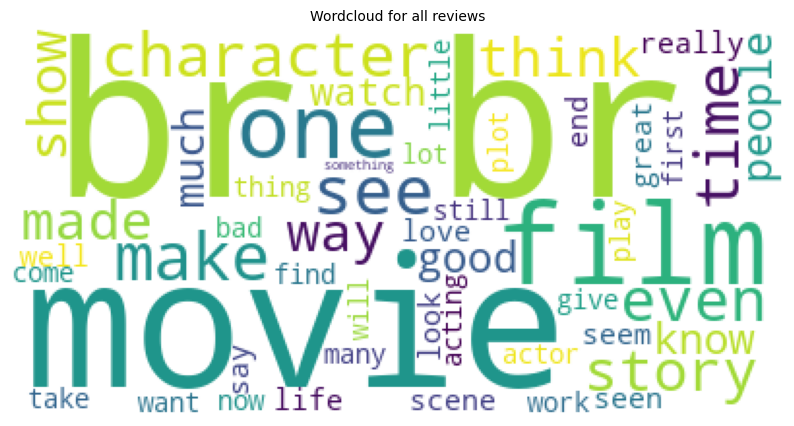

In [18]:
# Combine all reviews
reviews = " ".join([review for review in imdb['review']])
                        
# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('Wordcloud for all reviews', fontsize=10)
plt.axis('off')
plt.show()

In [ ]:
# Combine all reviews for each feedback category and splitting them into individual words
neg_reviews = " ".join([review for review in imdb[imdb['sentiment'] == 0]['review']])
neg_reviews = neg_reviews.lower().split()

pos_reviews = " ".join([review for review in imdb[imdb['sentiment'] == 1]['review']])
pos_reviews = pos_reviews.lower().split()

#Finding words from reviews which are present in that feedback category only
unique_negative = [x for x in neg_reviews if x not in pos_reviews]
unique_negative = " ".join(unique_negative)

unique_positive = [x for x in pos_reviews if x not in neg_reviews]
unique_positive = " ".join(unique_positive)


### Negative review unique words

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

### Positive review unique words

In [ ]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('Wordcloud for positive reviews', fontsize=10)
plt.axis('off')
plt.show()

# Preprocessing and Modelling

To build the corpus from the 'verified_reviews' we perform the following - <br>
1. Replace any non alphabet characters with a space
2. Covert to lower case and split into words
3. Iterate over the individual words and if it is not a stopword then add the stemmed form of the word to the corpus

In [ ]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, imdb.shape[0]):
  review = re.sub('[^a-zA-Z]', ' ', imdb.iloc[i]['review'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
  review = ' '.join(review)
  corpus.append(review)

# Comments transformation

In [ ]:
for i in range(10):
    print(corpus[i])

In [ ]:
for i in range(10):
    print(imdb.iloc[i]['review'])

In [ ]:
cv = CountVectorizer(max_features = 2500)

#Storing independent and dependent variables in X and y
X = cv.fit_transform(corpus).toarray()
y = imdb['sentiment'].values

Using Count Vectorizer to create bag of words

In [ ]:
#Saving the Count Vectorizer
pickle.dump(cv, open('Models/countVectorizer.pkl', 'wb'))

Checking the shape of X and y

In [ ]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Splitting data into train and test set with 30% data with testing.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 15)

print(f"X train: {X_train.shape}")
print(f"y train: {y_train.shape}")
print(f"X test: {X_test.shape}")
print(f"y test: {y_test.shape}")[InternetShortcut]
URL=http://localhost:8888/notebooks/Data%20Exploration%20&%20Modelling.ipynb


In [ ]:
print(f"X train max value: {X_train.max()}")
print(f"X test max value: {X_test.max()}")

We'll scale X_train and X_test so that all values are between 0 and 1.

# Min Max Scaler

In [ ]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [ ]:
#Saving the scaler model
pickle.dump(scaler, open('Models/scaler.pkl', 'wb'))

# Random Forest

In [ ]:
#Fitting scaled X_train and y_train on Random Forest Classifier
model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl, y_train)

In [ ]:
#Saving the Random Forest Classifier
pickle.dump(model_rf, open('Models/model_rf.pkl', 'wb'))

In [ ]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_rf.score(X_train_scl, y_train))
print("Testing Accuracy :", model_rf.score(X_test_scl, y_test))

In [ ]:
#Predicting on the test set
y_preds = model_rf.predict(X_test_scl)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

K fold cross-validation

In [ ]:
accuracies = cross_val_score(estimator = model_rf, X = X_train_scl, y = y_train, cv = 10)

print("Accuracy :", accuracies.mean())
print("Standard Variance :", accuracies.std())

Applying grid search to get the optimal parameters on random forest

In [ ]:
params = {
    'bootstrap': [True],
    'max_depth': [80, 100],
    'min_samples_split': [8, 12],
    'n_estimators': [100, 300]
}

In [ ]:
cv_object = StratifiedKFold(n_splits = 2)

grid_search = GridSearchCV(estimator = model_rf, param_grid = params, cv = cv_object, verbose = 0, return_train_score = True)
grid_search.fit(X_train_scl, y_train.ravel())

In [ ]:
#Getting the best parameters from the grid search


print("Best Parameter Combination : {}".format(grid_search.best_params_))

In [ ]:
print("Cross validation mean accuracy on train set : {}".format(grid_search.cv_results_['mean_train_score'].mean()*100))
print("Cross validation mean accuracy on test set : {}".format(grid_search.cv_results_['mean_test_score'].mean()*100))
print("Accuracy score for test set :", accuracy_score(y_test, y_preds))

### Saving the RandomForestClassifier with best parameters (as per grid search above) TODO

# XgBoost

In [ ]:
model_xgb = XGBClassifier()
model_xgb.fit(X_train_scl, y_train)

In [ ]:
#Saving the XGBoost classifier
pickle.dump(model_xgb, open('Models/model_xgb.pkl', 'wb'))

In [ ]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_xgb.score(X_train_scl, y_train))
print("Testing Accuracy :", model_xgb.score(X_test_scl, y_test))

In [ ]:
y_preds = model_xgb.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_xgb.classes_)
cm_display.plot()
plt.show()

# Decision Tree Classifier

In [ ]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_scl, y_train)

In [ ]:
#Saving the DecisionTreeClassifier classifier
pickle.dump(model_dt, open('Models/model_dt.pkl', 'wb'))

In [ ]:
#Accuracy of the model on training and testing data
 
print("Training Accuracy :", model_dt.score(X_train_scl, y_train))
print("Testing Accuracy :", model_dt.score(X_test_scl, y_test))

In [ ]:
y_preds = model_dt.predict(X_test)

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_preds)
print(cm)

In [ ]:
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model_dt.classes_)
cm_display.plot()
plt.show()

# Using models

## Models

In [ ]:
models_files = [
    "scaler.pkl",
    "model_rf.pkl",
    "model_xgb.pkl",
    "model_dt.pk1"
]

## Load Existing models
#### countVectorizer.pkl - cv - CountVectorizer
#### scaler.pkl - scaler - MinMaxScaler
#### model_rf.pkl - model_rf - RandomForestClassifier
#### model_xgb.pkl - model_xgb - XGBClassifier
#### model_dt.pk1 - model_dt - DecisionTreeClassifier

In [ ]:
cv = pickle.load(open(r"Models/countVectorizer.pkl", "rb"))
scaler = pickle.load(open(r"Models/scaler.pkl", "rb"))
model_rf = pickle.load(open(r"Models/model_rf.pkl", "rb"))
model_xgb = pickle.load(open(r"Models/model_xgb.pkl", "rb"))
model_dt = pickle.load(open(r"Models/model_dt.pkl", "rb"))

In [ ]:
def reviewTypeWithModel(predictor,text_input):
    # predictor = model_xgb
    # predictor = model_dt
    # scaler = scaler
    # cv = cv
    corpus = []
    stemmer = PorterStemmer()
    review = re.sub("[^a-zA-Z]", " ", text_input)
    review = review.lower().split()
    review = [stemmer.stem(word) for word in review if not word in STOPWORDS]
    review = " ".join(review)
    corpus.append(review)
    X_prediction = cv.transform(corpus).toarray()
    X_prediction_scl = scaler.transform(X_prediction)
    y_predictions = predictor.predict_proba(X_prediction_scl)
    y_predictions = y_predictions.argmax(axis=1)[0]

    return "Positive" if y_predictions == 1 else "Negative"

def reviewTypeRF(text):
    return reviewTypeWithModel(model_rf,text)

def reviewTypeXGB(text):
    return reviewTypeWithModel(model_xgb,text)

def reviewTypeDT(text):
    return reviewTypeWithModel(model_dt,text)

In [ ]:
review = """Storyline is really good so it's a story from Stephen King's book, how can be bad? But that's not enough to be the top rated movie of all time.

But people are confused about something. That thing is this movie is not the best movie of all time, it is the highest rated movie. That makes it doesn't matter your age or gender or what genre you like, you'll like this movie. Yes, it can be your favorite movie but objectively I won't trust your opinion on movies that much.

The movie has really good acting and screenplay and these are the most important things in a movie. Also Costume Design and Set Decoration is really good. But this movie average quality of Cinematography, Scores and Sound Effects. Okey maybe that scores or cinematography is not bad but we are talking about the top rated movie of all time. The Green Mile is directed by same person, Frank Darabont. And that movie has amazing Screenplay, Film Editing, Acting Cinematography, Makeups, Costumes, Art Direction and Set Decoration. All of them are really good, just scores are average. But as I sad in this movie we don't have amazing Cinematography, Film Editing, Original Scores..."""
print(reviewTypeRF(review))
print(reviewTypeXGB(review))
print(reviewTypeDT(review))

# Input Widget for using the review model

In [ ]:
import ipywidgets as widgets

In [ ]:
widgets.Textarea(
    value='Hello World',
    placeholder='Type something',
    description='String:',
    disabled=False
)
widgets.IntSlider()